# Model Evaluations

In [1]:
import s3fs
import boto3
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
from copy import copy

## Get the Data

In [7]:
results_1000 = pd.read_csv('results_1000.csv')
train_1000_labeled = pd.read_csv('s3://ec2-jupyter-notebook-us-west-2-8c94c42abbd5478ca9a1a477613965a7/train_1000_labeled - train (1).csv') #labeled data

In [8]:
results_1000

,Unnamed: 0,sequence,labels,scores
0,0,From the Wall Street Journal and #1 Amazon bes...,"['relationships', 'friendship', 'weddings', 'f...","[0.810408353805542, 0.7846238017082214, 0.3569..."
1,1,Helping set the stage for BioWare's hotly anti...,"['weddings', 'university', 'relationships', 'f...","[0.6858078241348267, 0.5801675915718079, 0.556..."
2,2,"Sebastian Locke, the fifty-six-year-old patria...","['weddings', 'relationships', 'family', 'unive...","[0.8171698451042175, 0.7892597317695618, 0.694..."
3,3,"""Take me back to Oxmoon, the lost paradise of ...","['family', 'break ups', 'relationships', 'deat...","[0.8995345830917358, 0.7834796905517578, 0.666..."
4,4,"When the Mayflower set sail in 1620, it carrie...","['weddings', 'relationships', 'family', 'death...","[0.30325835943222046, 0.20769745111465454, 0.1..."
...,...,...,...,...
995,995,Lee wants to be a Tarantula – a member of the ...,"['friendship', 'weddings', 'family', 'relation...","[0.6196390986442566, 0.5734032988548279, 0.216..."
996,996,The Merry Adventures of Robin Hood of Great Re...,"['break ups', 'relationships', 'university', '...","[0.4580182433128357, 0.26883089542388916, 0.26..."
997,997,Moving from present-day Oslo to Brooklyn in th...,"['family', 'relationships', 'divorce', 'weddin...","[0.9842621088027954, 0.9696624875068665, 0.169..."
998,998,"The captivating sequel to INKHEART, the critic...","['weddings', 'family', 'relationships', 'unive...","[0.8809835314750671, 0.6902908682823181, 0.662..."


## Reformat Data

In [4]:
from ast import literal_eval
results_1000['labels'] = results_1000['labels'].apply(lambda row: literal_eval(row))
results_1000['scores'] = results_1000['scores'].apply(lambda row: literal_eval(row))

In [5]:
results_1000['dictionary'] = results_1000.apply(lambda row: dict(zip(row['labels'], row['scores'])), axis=1)

In [6]:
LE_columns = results_1000['dictionary'].apply(pd.Series)
ZS_classifications = LE_columns > 0.5

In [7]:
train_1000_labeled = train_1000_labeled.replace(np.nan, False)

In [77]:
train_1000_labeled.to_csv('train_1000_labeled.csv')

In [13]:
train_1000_labeled

,index,Unnamed: 0,bookId,title,series,author,rating,description,language,isbn,...,university,relationships,break ups,divorce,weddings,death,family,friendship,labeled?,Contains True?
0,0,"39,822",34838660-not-part-of-the-plan,Not Part of the Plan,Blue Moon #4,Lucy Score (Goodreads Author),4.46,From the Wall Street Journal and #1 Amazon bes...,English,B06Y695J64,...,False,True,False,False,False,False,False,False,Yes,1.0
1,1,"34,235",20176552-dragon-age-volume-1,"Dragon Age, Volume 1",Dragon Age Graphic Novels #1-3,"David Gaider, Chad Hardin (Illustrator), Antho...",4.26,Helping set the stage for BioWare's hotly anti...,English,"9,780,000,000,000.00",...,False,False,False,False,False,False,False,False,Yes,0.0
2,2,"27,904",124110.Dangerous_to_Know,Dangerous to Know,False,Barbara Taylor Bradford (Goodreads Author),3.73,"Sebastian Locke, the fifty-six-year-old patria...",English,"9,780,000,000,000.00",...,False,True,False,True,False,True,True,False,Yes,1.0
3,3,"10,515",1046450.The_Wheel_of_Fortune,The Wheel of Fortune,False,Susan Howatch,4.11,"""Take me back to Oxmoon, the lost paradise of ...",English,"9,780,000,000,000.00",...,False,True,False,False,False,False,True,False,Yes,1.0
4,4,935,872333.Blue_Bloods,Blue Bloods,Blue Bloods #1,Melissa de la Cruz (Goodreads Author),3.69,"When the Mayflower set sail in 1620, it carrie...",English,"9,780,000,000,000.00",...,False,False,False,False,False,False,False,False,Yes,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,"17,361",588326.The_Blue_Helmet,The Blue Helmet,False,William Bell,3.42,Lee wants to be a Tarantula – a member of the ...,English,"9,780,000,000,000.00",...,False,False,False,False,False,False,False,True,False,1.0
996,996,"9,029",93007.The_Merry_Adventures_of_Robin_Hood,The Merry Adventures of Robin Hood,False,Howard Pyle,4.07,The Merry Adventures of Robin Hood of Great Re...,English,"9,780,000,000,000.00",...,False,False,False,False,False,False,False,False,False,0.0
997,997,"32,216",1085376.Before_You_Sleep,Before You Sleep,False,"Linn Ullmann, Tiina Nunnally (Translator)",3.34,Moving from present-day Oslo to Brooklyn in th...,English,"9,780,000,000,000.00",...,False,False,False,False,False,False,True,False,False,1.0
998,998,"1,036",28195.Inkspell,Inkspell,Inkworld #2,"Cornelia Funke (Goodreads Author), Anthea Bell...",3.91,"The captivating sequel to INKHEART, the critic...",English,"9,780,000,000,000.00",...,False,False,False,False,False,False,False,False,False,0.0


In [10]:
ZS_classifications

,relationships,friendship,weddings,family,break ups,university,death,divorce
0,True,True,False,False,False,False,False,False
1,True,False,True,False,False,True,False,False
2,True,False,True,True,False,True,False,False
3,True,False,False,True,True,False,True,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
995,False,True,True,False,False,False,False,False
996,False,False,False,False,False,False,False,False
997,True,False,False,True,False,False,False,False
998,True,True,True,True,False,True,False,False


In [ ]:
sklearn.metrics.f1_score(results_1000

## Evaluation Function

In [11]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

In [74]:
def eval_func(results, true_labels):
    LE_metrics = [] #returns confusion matrix and metrics for each life_event, need to add overall 
    eval_dict = {}
    for life_event in ['weddings', 'friendship', 'family', 'break ups', 'relationships', 'death', 'divorce', 'university']:
        cm = confusion_matrix(true_labels[life_event], results[life_event], labels=[False, True])
        TN, FP, FN, TP = cm.ravel()
        print(life_event.upper(), " Confusion Matrix")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        eval_dict['Recall or TPR'] = copy(TPR)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        eval_dict['Specificity or TNR'] = copy(TNR)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        eval_dict['Precision or PPV'] = copy(PPV)
        # Negative predictive value
        NPV = TN/(TN+FN)
        eval_dict['Negative Predictive Value'] = copy(NPV)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        eval_dict['False Positive Rate'] = copy(FPR)
        # False negative rate
        FNR = FN/(TP+FN)
        eval_dict['False Negative Rate'] = copy(FNR)
        # False discovery rate
        FDR = FP/(TP+FP)
        eval_dict['False Discovery Rate'] = copy(FDR)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        eval_dict['Accuracy'] = copy(ACC)
        LE_metrics.append(copy(eval_dict))
    df = pd.DataFrame.from_records(LE_metrics, index = ['weddings', 'friendship', 'family', 'break ups', 'relationships', 'death', 'divorce', 'university'])
    return df

# Zero-shot Evaluation

WEDDINGS  Confusion Matrix


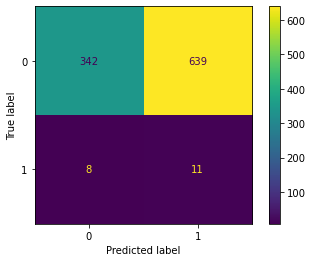

FRIENDSHIP  Confusion Matrix


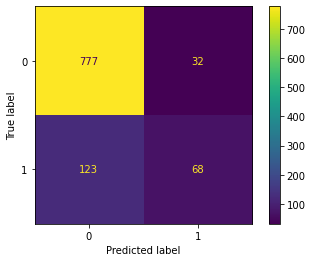

FAMILY  Confusion Matrix


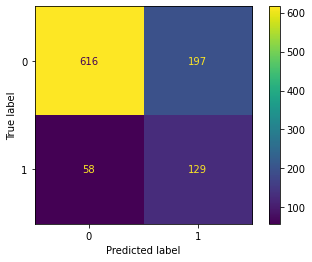

BREAK UPS  Confusion Matrix


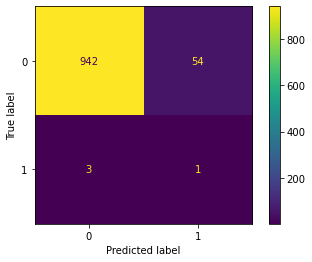

RELATIONSHIPS  Confusion Matrix


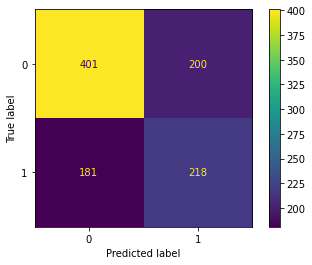

DEATH  Confusion Matrix


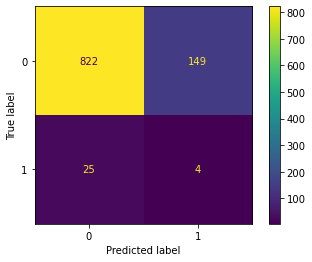

DIVORCE  Confusion Matrix


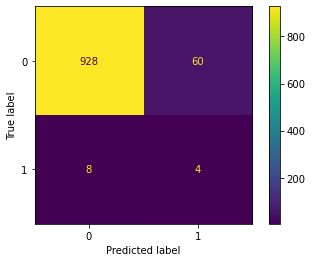

UNIVERSITY  Confusion Matrix


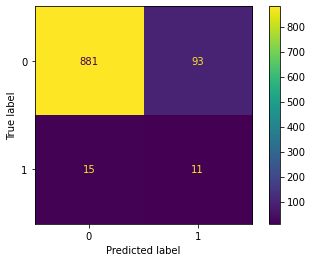

,Recall or TPR,Specificity or TNR,Precision or PPV,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate,Accuracy
weddings,0.578947,0.348624,0.016923,0.977143,0.651376,0.421053,0.983077,0.353
friendship,0.356021,0.960445,0.680000,0.863333,0.039555,0.643979,0.320000,0.845
family,0.689840,0.757688,0.395706,0.913947,0.242312,0.310160,0.604294,0.745
break ups,0.250000,0.945783,0.018182,0.996825,0.054217,0.750000,0.981818,0.943
relationships,0.546366,0.667221,0.521531,0.689003,0.332779,0.453634,0.478469,0.619
death,0.137931,0.846550,0.026144,0.970484,0.153450,0.862069,0.973856,0.826
divorce,0.333333,0.939271,0.062500,0.991453,0.060729,0.666667,0.937500,0.932
university,0.423077,0.904517,0.105769,0.983259,0.095483,0.576923,0.894231,0.892


In [75]:
eval_func(ZS_classifications, train_1000_labeled)

In [20]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

In [9]:
zero_shot_pred = pd.read_csv('ZS_classifications.csv')
true_labels = pd.read_csv('train_1000_labeled.csv')

In [11]:
p = zero_shot_pred[['relationships', 'friendship', 'weddings', 'family', 'break ups', 'university', 'death', 'divorce']]

In [17]:
p

,relationships,friendship,weddings,family,break ups,university,death,divorce
0,True,True,False,False,False,False,False,False
1,True,False,True,False,False,True,False,False
2,True,False,True,True,False,True,False,False
3,True,False,False,True,True,False,True,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
995,False,True,True,False,False,False,False,False
996,False,False,False,False,False,False,False,False
997,True,False,False,True,False,False,False,False
998,True,True,True,True,False,True,False,False


In [13]:
t = true_labels[['relationships', 'friendship', 'weddings', 'family', 'break ups', 'university', 'death', 'divorce']]

In [15]:
t = t.replace(np.nan, False)

In [16]:
labels =['relationships', 'friendship', 'weddings', 'family', 'break ups', 'university', 'death', 'divorce']
y_true = np.array(p.values.tolist())
y_pred = np.array(t.values.tolist())

print(classification_report(y_true, y_pred, target_names=labels))

               precision    recall  f1-score   support

relationships       0.55      0.52      0.53       418
   friendship       0.36      0.68      0.47       100
     weddings       0.58      0.02      0.03       650
       family       0.69      0.40      0.50       326
    break ups       0.25      0.02      0.03        55
   university       0.42      0.11      0.17       104
        death       0.14      0.03      0.04       153
      divorce       0.33      0.06      0.11        64

    micro avg       0.51      0.24      0.33      1870
    macro avg       0.41      0.23      0.24      1870
 weighted avg       0.52      0.24      0.26      1870
  samples avg       0.31      0.19      0.21      1870



/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
bert_FT = pd.read_csv('bert_finetuned_test_val_results_2.csv')
bert_true = pd.read_csv('dataset_bert_test.csv')

In [42]:
bert_list = ['university',
 'relationships',
 'break ups',
 'divorce',
 'weddings',
 'death',
 'family',
 'friendship']

In [43]:
p = bert_FT[['scores']]
t = bert_FT[['university',
 'relationships',
 'break ups',
 'divorce',
 'weddings',
 'death',
 'family',
 'friendship']]

In [44]:
p

,scores
0,"[0.036931127309799194, 0.339970201253891, 0.02..."
1,"[0.04035283625125885, 0.21228797733783722, 0.0..."
2,"[0.04113070294260979, 0.17052049934864044, 0.0..."
3,"[0.053780216723680496, 0.6612476706504822, 0.0..."
4,"[0.03974013403058052, 0.38684311509132385, 0.0..."
...,...
294,"[0.04318717494606972, 0.5767211318016052, 0.02..."
295,"[0.03878506273031235, 0.2841522693634033, 0.02..."
296,"[0.04621046409010887, 0.13617829978466034, 0.0..."
297,"[0.04569709673523903, 0.5106881856918335, 0.03..."


In [45]:
p['labels'] = str(bert_list)

/tmp/ipykernel_2558/2475124451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['labels'] = str(bert_list)


In [46]:
p

,scores,labels
0,"[0.036931127309799194, 0.339970201253891, 0.02...","['university', 'relationships', 'break ups', '..."
1,"[0.04035283625125885, 0.21228797733783722, 0.0...","['university', 'relationships', 'break ups', '..."
2,"[0.04113070294260979, 0.17052049934864044, 0.0...","['university', 'relationships', 'break ups', '..."
3,"[0.053780216723680496, 0.6612476706504822, 0.0...","['university', 'relationships', 'break ups', '..."
4,"[0.03974013403058052, 0.38684311509132385, 0.0...","['university', 'relationships', 'break ups', '..."
...,...,...
294,"[0.04318717494606972, 0.5767211318016052, 0.02...","['university', 'relationships', 'break ups', '..."
295,"[0.03878506273031235, 0.2841522693634033, 0.02...","['university', 'relationships', 'break ups', '..."
296,"[0.04621046409010887, 0.13617829978466034, 0.0...","['university', 'relationships', 'break ups', '..."
297,"[0.04569709673523903, 0.5106881856918335, 0.03...","['university', 'relationships', 'break ups', '..."


In [47]:
from ast import literal_eval
p['labels'] = p['labels'].apply(lambda row: literal_eval(row))
p['scores'] = p['scores'].apply(lambda row: literal_eval(row))
p['dictionary'] = p.apply(lambda row: dict(zip(row['labels'], row['scores'])), axis=1)
p_columns = p['dictionary'].apply(pd.Series)
FT_classifications = p_columns > 0.5

/tmp/ipykernel_2558/866857270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['labels'] = p['labels'].apply(lambda row: literal_eval(row))
/tmp/ipykernel_2558/866857270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['scores'] = p['scores'].apply(lambda row: literal_eval(row))
/tmp/ipykernel_2558/866857270.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [48]:
FT_classifications

,university,relationships,break ups,divorce,weddings,death,family,friendship
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
294,False,True,False,False,False,False,False,False
295,False,False,False,False,False,False,False,False
296,False,False,False,False,False,False,False,False
297,False,True,False,False,False,False,False,False


In [49]:
labels =['university',
 'relationships',
 'break ups',
 'divorce',
 'weddings',
 'death',
 'family',
 'friendship']
y_true = np.array(t.values.tolist())
y_pred = np.array(FT_classifications.values.tolist())

print(classification_report(y_true, y_pred, target_names=labels))

               precision    recall  f1-score   support

   university       0.00      0.00      0.00         7
relationships       0.78      0.77      0.77       124
    break ups       0.00      0.00      0.00         0
      divorce       0.00      0.00      0.00         3
     weddings       0.00      0.00      0.00         6
        death       0.00      0.00      0.00         5
       family       0.00      0.00      0.00        46
   friendship       0.00      0.00      0.00        53

    micro avg       0.78      0.39      0.52       244
    macro avg       0.10      0.10      0.10       244
 weighted avg       0.40      0.39      0.39       244
  samples avg       0.32      0.24      0.27       244



/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/pyth

In [50]:
bert_Top = pd.read_csv('semi_sv_bertopic_results.csv')
bert_true = pd.read_csv('dataset_bert_test.csv')

In [53]:
bert_Top = bert_Top[['university',
 'relationships',
 'break ups',
 'divorce',
 'weddings',
 'death',
 'family',
 'friendship']]

bert_true = bert_true[['university',
 'relationships',
 'break ups',
 'divorce',
 'weddings',
 'death',
 'family',
 'friendship']]

In [52]:
bert_true

,Unnamed: 0,ID,description,university,relationships,break ups,divorce,weddings,death,family,friendship
0,700,"32,911",The author of Hot Summer Nights offers a Sex i...,False,True,False,False,False,False,False,False
1,701,"49,078",At the outset of this adventure filled with di...,False,False,False,False,False,False,False,False
2,702,"14,671",The Dark Knight's greatest enemies have all si...,False,False,False,False,False,False,False,False
3,703,"26,759","Lady Emily Marlowe was beautiful, wild, and un...",False,True,False,False,False,False,False,False
4,704,"23,033",The first book of a thrilling new military sci...,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
194,894,"31,481","Orphaned, raised by wolves, and the proud owne...",False,True,False,False,False,False,False,False
195,895,"38,292",**STILL is the conclusion of Grip & Bristol's ...,False,True,False,False,False,False,False,False
196,896,"8,513","Losing Lucian McKenzie, the Prince of her hear...",False,True,False,False,False,False,False,False
197,897,"26,040",With her sensual blend of paranormal romance a...,False,True,False,False,False,False,False,False


In [54]:
labels =['university',
 'relationships',
 'break ups',
 'divorce',
 'weddings',
 'death',
 'family',
 'friendship']
y_true = np.array(bert_true.values.tolist())
y_pred = np.array(bert_Top.values.tolist())

print(classification_report(y_true, y_pred, target_names=labels))

               precision    recall  f1-score   support

   university       0.00      0.00      0.00         5
relationships       0.25      0.01      0.02        79
    break ups       0.00      0.00      0.00         0
      divorce       0.00      0.00      0.00         2
     weddings       0.00      0.00      0.00         5
        death       0.00      0.00      0.00         4
       family       1.00      0.03      0.07        29
   friendship       0.00      0.00      0.00        36

    micro avg       0.18      0.01      0.02       160
    macro avg       0.16      0.01      0.01       160
 weighted avg       0.30      0.01      0.02       160
  samples avg       0.00      0.01      0.01       160



/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/pyth